# INF8775 – Analyse et conception d’algorithmes
# TP2 – Automne 2025

Perron Touchette, Thomas, 2201589

Benouhoud, Mehdi, 2188585

Note finale :

 <u>**Date limite de remise :**</u>  11 novembre 23h59 (Groupe B1), 4 novembre 23h59 (Groupe B2)

# Instructions

## Rédaction et remise du rapport

- Ce notebook constitue à la fois le sujet du TP, votre code et votre rapport. Il contient déjà du code pour faciliter vos mesures et l'affichage de vos résultats, ainsi qu'un squelette pour votre rapport.

- Complétez directement le notebook, vous êtes libres de créer de nouvelles cellules de code ou de texte.

- Remettez le fichier du notebook sur Moodle avec le nom `NOM1_MATRICULE1_NOM2_MATRICULE2.ipynb`

- Vous pouvez inclure du code trouvé sur Internet, mais vous devez en mentionner la source, sous peine d'être sanctionnés pour plagiat.  Cela s'applique aussi au niveau de l'IA générative pour le code. Par contre, vous devez être capable d'accomplir les analyses par vous-même. Vous ne pouvez pas utiliser l'IA pour ces sections.
## Mise en situation

Ce travail pratique se répartit sur deux séances de laboratoire et porte sur l'analyse et la conception d'algorithmes développés suivant différents patrons de conception afin de résoudre une version simplifiée d'un problème réaliste d'optimisation.


## Description du problème

Un pianiste souhaite jouer une mélodie donnée par une partition. La mélodie est une suite de n notes *(a0, a1, ... , an-1)* où chaque ai appartient à un ensemble de m notes numérotées de 0 à m-1.

Le pianiste peut choisir de jouer chaque note avec l’un de ses D doigts. Le passage de la note i1 jouée avec le doigt d1 à la note i2 jouée avec le doigt d2 est pénalisée par une fonction de difficulté de la transition *C(i1, d1, i2, d2)*. Notre pianiste souhaite donc déterminer avec quel doigt il doit jouer chaque note de la mélodie de façon à minimiser la somme des coûts de chaque transition.

Pour la partie empirique de ce TP, nous nous limiterons à des mélodies jouées à une main (D=5) sur deux octaves (m=24).

Soit l’exemple suivant avec 5 notes :

- L'exemplaire est : `[17, 21, 18, 2, 21, 15, 11, 16]`
- La solution est : `[2, 1, 1, 0, 1, 1, 2, 1]`

La figure ci-dessous représente la partition avec ça solution et le coût associé à chaque transition.

![alt text](example_solution.png "Title")

## Algorithmes à implanter

Trois algorithmes seront implantés, mettant en pratique des patrons de conception différents :

1. Un algorithme glouton
2. Un algorithme de programmation dynamique
3. Un algorithme de recherche locale


## Jeu de données

La fonction `generate_sample` ci-dessous permet de générer un exemplaire d'une taille donnée.

La fonction `get_dataset` permet de récupérer un dataset pour la liste de taille fournie. Elle prend également en entrée un graine aléatoire pour générer le dataset en question.

Afin que chaque groupe travaille avec un set différent, mais que vos propres expériences soient reproductibles, entrez l'un de vous matricule comme graine aléatoire dans la cellule ci-dessous.

Vous êtes bien entendu libres de tester et mesurer vos algorithme sur le même dataset qu'un autre groupe. Pour cela, générez simplement un dataset avec la même graine et la même liste de taille.



In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.stats import linregress
import time
from collections.abc import Callable

In [10]:
def visualize_solution(costs, partition, solution):
    """
    Visualisez votre solution et les coûts associés.
    """
    # Create a figure and axis
    _, ax = plt.subplots()

    # Plot the notes as circles with their sizes proportional to the partition values
    for i in range(len(partition)):
        ax.scatter([i], [partition[i]], marker='o')
        ax.text(i, partition[i] + 0.2, str(solution[i]), ha='center', va='bottom')

    # Set the limits for the axes to fit the plot
    ax.set_ylim(min(partition) - 1, max(partition) + 1)
    ax.set_xlim(-0.5, len(partition)-0.5)

    # Label the axes
    ax.set_xlabel('Partition')
    ax.set_ylabel('Note')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    # Title the plot
    ax.set_title('Partition et doigts utilisés')

    plot_costs = getCosts(costs, partition, solution).tolist()
    plot_costs.append(0)

    ax2 = ax.twinx()
    ax2.bar(range(len(partition)), plot_costs, width=1, alpha=0.5, align='edge', color='gray')
    ax2.set_xlim(-0.5, len(partition)-0.5)
    ax2.set_ylim(0, 100)

    # Remove the ticks and tick labels from the secondary y-axis
    ax2.tick_params(axis='both', which='both', length=0)
    ax2.set_yticklabels([])
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    # Show the plot
    plt.show()

def generate_sample(size, maxValue=24):
    return np.random.randint(0, maxValue, size).tolist()

def get_dataset(seed, sizes, nbSamples=5):
    np.random.seed(seed)
    return { size: [generate_sample(size) for _ in range(nbSamples)]
        for size in sizes }

def readFile(filePath):
    """
    Charger une partition depuis un fichier
    """
    f = open(filePath)
    _ = int(f.readline())
    partition = list(map(int, f.readline().split(' ')))
    f.close()
    return partition

def getCosts(costs, partition, solution):
    """
    Liste des coûts associés à chaque transition de votre solution.
    """
    prevNotes, nextNotes = partition[:-1], partition[1:]
    prevFingers, nextFingers = solution[:-1], solution[1:]
    return costs[prevNotes, prevFingers, nextNotes, nextFingers]

def getTotalCost(costs, partition, solution):
    """
    Coût total de votre solution
    """
    return np.sum(getCosts(costs, partition, solution))

Exécutez la cellule suivante afin d'obtenir le tenseur des coûts associé à chaque transition.

In [43]:
load_file = np.loadtxt('cout_transition.txt', dtype=int)
costs = load_file.reshape((24, 5, 24, 5))
D = 5    # Nombre de doigts
M = 24   # Etendue des notes (2 octaves)

partition = readFile('Chansons/twinkle_twinkle.txt')

data_set = get_dataset(2188585, [25, 50, 75, 100, 250, 500, 750, 1_000, 1_500, 2_500, 5_000], 3)

# Implantations et expérimentations

Ces fonctions auxiliaires vous sont fournies pour vérifier l'exactitude des vos algorithmes, mesurer leurs performance et afficher vos résultats.

Il est recommandé de prendre le temps de lire et comprendre le code.

Exécutez la cellule ci-dessous pour pouvoir utiliser les fonctions auxiliaires.

In [45]:
class Measure():
    """A wrapper to contain information on taken measures"""
    def __init__(self, size: int, mean: int, score: int) -> None:
        self.size = size
        self.mean_score = score
        self.mean = mean

def is_valid_solution(original: list[int], solution: list[int]) -> bool:
    """Validates solution"""

    n = len(original)

    if len(solution)!=n:
      return False

    for i in range(n):
        if solution[i]<0 or solution[i]>=D:
            return False

    # Solution is valid
    return True

def measure(procedure: Callable, sample: list[int], costs,  time_scale: int) -> tuple[int, int]:
    """Returns the time in milliseconds taken to run the procedure.

    Raises:
        InvalidSolution: If the procedure returns an invalid solution, raises an exception.
    """
    start: int = time.time() * time_scale
    solution: list[int] = procedure(sample)
    end: int = time.time() * time_scale
    if not is_valid_solution(sample, solution):
        raise InvalidSolution()
    score = getTotalCost(costs, sample, solution)
    return (round(end - start), score)


def measure_mean(procedure: Callable, samples: list[list[int]], size: int, costs, time_scale: int) -> Measure:
    """Generates multiple samples with the specified parameters and returns the mean time in milliseconds

    Raises:
        InvalidSolution: If one of the samples results in an invalid solution.
    """
    results=[measure(procedure, sample, costs, time_scale) for sample in samples]
    mean_time = sum(
        [result[0] for result in results]
    ) / len(samples)
    mean_score = sum(
        [result[1] for result in results]
    ) / len(samples)
    return Measure(size, mean_time, mean_score)

def measure_procedure(procedure: Callable, dataset: list[list[list[int]]], costs,  time_scale: int = 1000) -> list[Measure]:
    """Measures the mean time taken in milliseconds for each size in the given list.

    Raises:
        InvalidSolution: If one of the samples results in an invalid solution.

    Returns:
        A list of Measure instances containing the specifications
        of the problem as well as the mean time.
    """
    return [
        measure_mean(procedure, samples, size, costs, time_scale)
        for size, samples in dataset.items()
    ]


def display_measures_table(measures: list[Measure]):
    """Prints a table with the data in the given list of measures"""
    print("{: <16} {: <16} {: <16}".format("Taille", "Temps moyen", "Score moyen"))
    for measure in measures:
        print("{: <16} {: <16} {: <16}".format(measure.size, measure.mean, measure.mean_score))

def display_test_puissance(vals, title="Test de puissance"):
    x = list(vals.keys())
    y = list(vals.values())

    # Perform linear regression
    m, b, rvalue, _, _ = linregress(x, y)
    r = list(map(lambda x : m*x + b, x))

    # Create the line equation
    line_eq = f"y = {m:.2f}x + {b:.2f}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, r, color="red", label=f'Regression linéaire R²={round(rvalue**2,4)}')

    # Add labels and title
    plt.xlabel('log Taille')
    plt.ylabel('log Temps')
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

def display_test_rapport(vals, title="Test du rapport"):
    x = list(vals.keys())
    y = list(vals.values())

    plt.plot(x, y, label='Mesures')
    plt.scatter(x, y, label='Mesures')

    # Add labels and title
    plt.xlabel('Taille')
    plt.ylabel('Temps / f(taille)')
    plt.title(title)
    plt.show()


def display_test_constantes(vals, title="Test des constantes"):
    x = list(vals.keys())
    y = list(vals.values())

    # Perform linear regression
    m, b, rvalue, _, _ = linregress(x, y)

    r = list(map(lambda x : m*x + b, x))

    # Create the line equation
    line_eq = f"y = {m:.2E}x + {b:.2E}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, r, color="red", label=f'Regression linéaire R²={round(rvalue**2,4)}')

    # Add labels and title
    plt.xlabel('f(Taille)')
    plt.ylabel('Temps')
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

## Partie 1 : Algorithme glouton (6 points)

Implantez un algorithme suivant le patron de conception glouton.

L'algorithme glouton fait son choix en fonction du coût de la prochaine transition :

Les deux premiers doigts d0 et d1 sont choisis de façon à minimiser C(a0, d0, a1, d1). Puis, étant donné le
doigt précédent d et la transition de la note i vers la note j, le choix glouton porte sur le doigt d’ qui
minimise C(i, d, j, d’).

Tentez de rendre votre implantation la plus performante possible en évitant des calculs inutiles.

Coût Glouton : 143


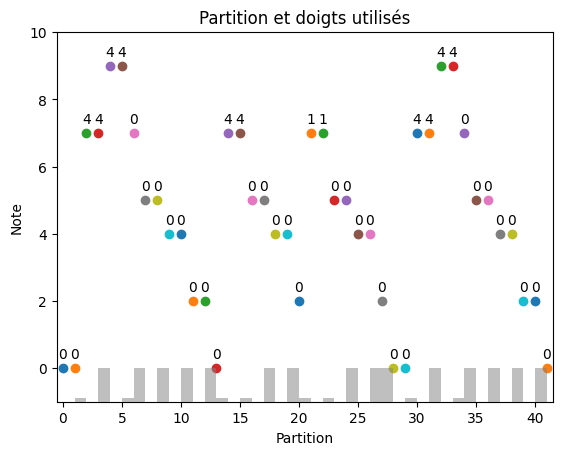

La solution gloutonne est valide.


In [27]:
def greedy_choice(current_note: int, next_note: int, previous_finger: int, nb_available_fingers: int) -> int:
    lowest_cost = float('inf')
    current_best_finger = 0

    for finger in range(nb_available_fingers): # Complexité de O(D)
        cost = getCosts(costs, [current_note, next_note], [previous_finger, finger])[0]
        if cost < lowest_cost:
            lowest_cost = cost
            current_best_finger = finger

    return current_best_finger
                  
def glouton(partition):
    partition_length = len(partition)
    if partition_length == 0: return []

    solution = [0 for _ in range(partition_length)] # Complexité de O(N)

    lowest_cost = float('inf')
    best_first_finger, best_second_finger = 0, 0

    for first_finger in range(D): # Complexité de O(D)
        for second_finger in range(D): # Complexité de O(D)
            cost = getCosts(costs, partition[:2], [first_finger, second_finger])[0]
            if cost < lowest_cost:
                lowest_cost = cost
                best_first_finger, best_second_finger = first_finger, second_finger

    solution[0], solution[1] = best_first_finger, best_second_finger

    for i in range(2, partition_length): # Complexité de O(N)
        solution[i] = greedy_choice(partition[i-1], partition[i], solution[i-1], D) # Complexité O(D)

    return solution

solutionGlouton = glouton(partition)
print("Coût Glouton :", getTotalCost(costs, partition, solutionGlouton))
visualize_solution(costs, partition, solutionGlouton)

if is_valid_solution(partition, solutionGlouton):
    print("La solution gloutonne est valide.")
else:
    print("La solution gloutonne n'est pas valide.")

### Analyse asymptotique

Dans cette analyse, vous tiendrez compte à la fois de la longueur de la mélodie mais également du
nombre de doigts pour chacun des trois algorithmes.

Tel que nous pouvons l'observer dans les commentaires que nous avons laisser dans le code, la complexité asymptotique est de O(N + D<sup>2</sup> + N \* D). Nous savons que la complexité sera donc dans O(max(N, D<sup>2</sup>, N\*D)). Nous savons que le nombre de doigts est négligeable par rapport à la longueur de la mélodie. Ces deux valeurs sont strictement postives donc max(N, D<sup>2</sup>, N\*D) = max(N, N\*D) = N\*D, notre algorithme glouton est donc dans O(N\*D) qui est dans O(N)

### Mesures

Rapportez dans un tableau les temps d'exécutions moyens avec les fonctions auxiliaires `measure_procedure` et `display_measure_table`

In [66]:
matricule = 2188585
measures_glouton = measure_procedure(glouton, data_set, costs)
display_measures_table(measures_glouton)

Taille           Temps moyen      Score moyen     
25               1.6666666666666667 267.3333333333333
50               2.0              602.0           
75               4.333333333333333 1172.3333333333333
100              3.0              1339.3333333333333
250              7.0              3543.0          
500              14.0             7110.666666666667
750              20.333333333333332 11791.333333333334
1000             26.666666666666668 14791.666666666666
1500             45.666666666666664 22310.333333333332
2500             68.0             37841.333333333336
5000             141.0            74738.0         


### Validation empirique

Servez-vous de vos temps d'exécution pour confirmer et/ou préciser l'analyse asymptotique théorique de vos algorithmes avec la méthode hybride de votre choix.

La méthode peut varier d'un algorithme à l'autre. Justifiez les choix ici et avec des graphiques.

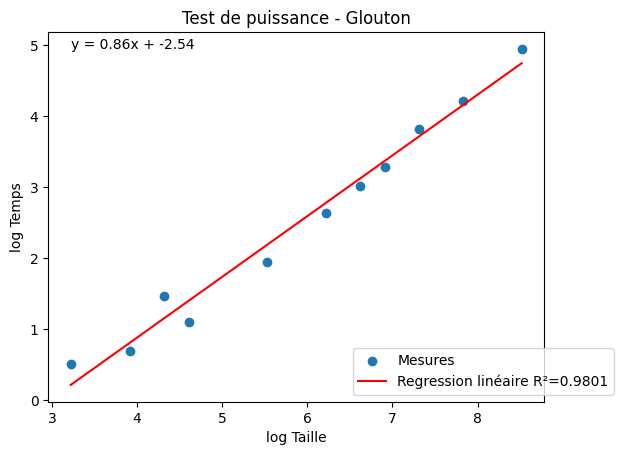

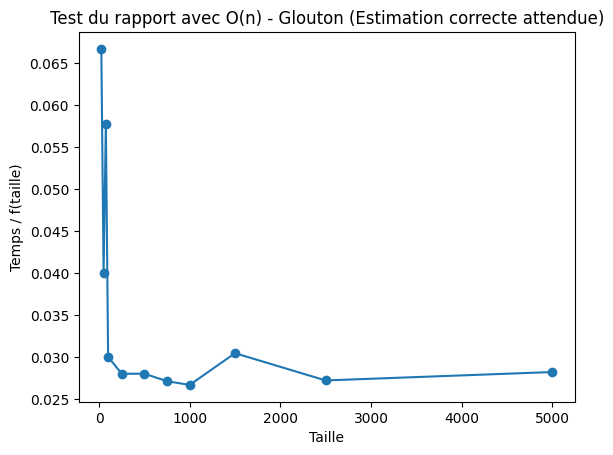

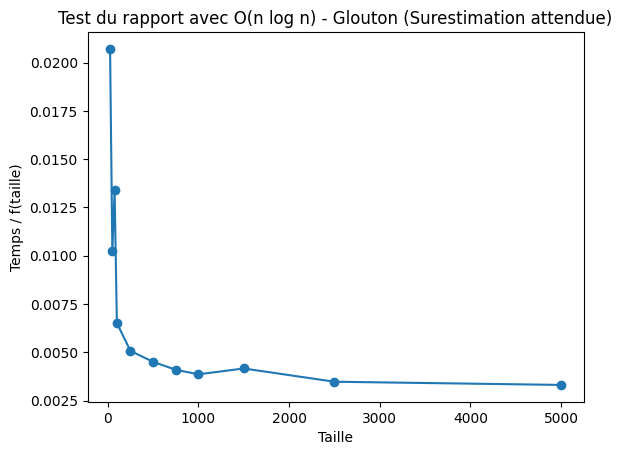

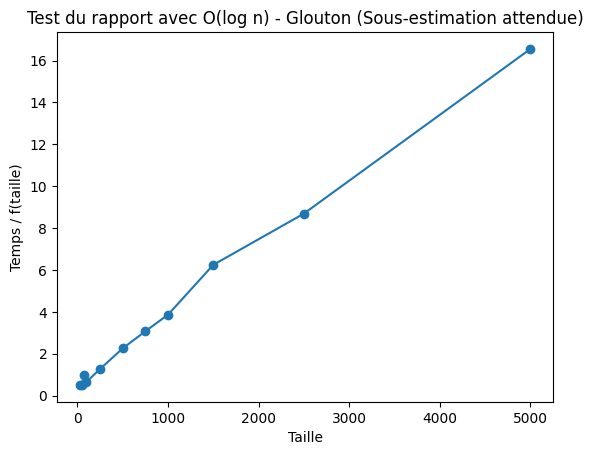

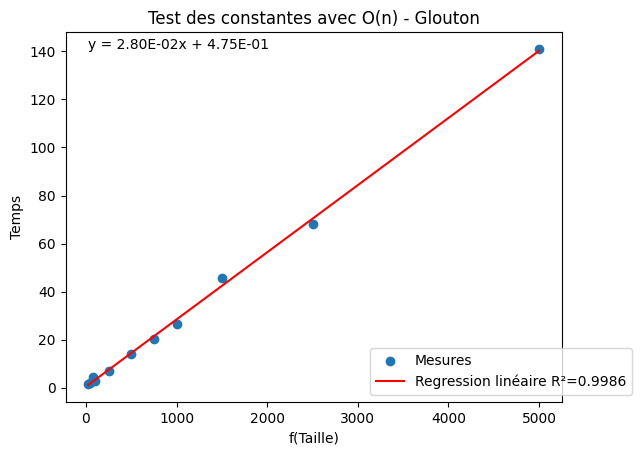

In [67]:
import math
def values_test_puissance(measures):
    return {
        math.log(measure.size): math.log(measure.mean)
        for measure in measures
        }

def values_test_rapport(measures, f):
    return {
        measure.size: measure.mean / f(measure.size)
        for measure in measures
        }

def rapport_fonction(n):
    return n

def rapport_fonction_more_complex(n):
    return n * math.log(n)

def rapport_fonction_less_complex(n):
    return math.log(n)

def values_test_constantes(measures, f):
    return {
        f(measure.size): measure.mean
        for measure in measures
         }

display_test_puissance(values_test_puissance(measures_glouton), title="Test de puissance - Glouton")
display_test_rapport(values_test_rapport(measures_glouton, rapport_fonction), title="Test du rapport avec O(n) - Glouton (Estimation correcte attendue)")
display_test_rapport(values_test_rapport(measures_glouton, rapport_fonction_more_complex), title="Test du rapport avec O(n log n) - Glouton (Surestimation attendue)")
display_test_rapport(values_test_rapport(measures_glouton, rapport_fonction_less_complex), title="Test du rapport avec O(log n) - Glouton (Sous-estimation attendue)")
display_test_constantes(values_test_constantes(measures_glouton, rapport_fonction), title="Test des constantes avec O(n) - Glouton")

1. Le test de puissance nous montre que les résultats suivent une croissance linéaire en O(n<sup>0.86</sup>). Or, comme il peut il y avoir du bruit, il est normal que le résultat de cette régression linéaire soit légèrement inférieure à la réelle complexité algorithmique. Nous concluons donc à une complexité de O(n)

2. 

a. Le graphique du test du rapport pour O(n) montre des valeurs qui tournent autour de 0.030, c'est-à-dire une convergence vers une valeur supérieure à 0. Le graphique confirme donc l'estimation

b. Le graphique du test du rapport pour O(n*log(n)), une surestimation converge bien vers 0, ce qui nous confirme que la complexité algorithmique est inférieure à O(n\*log(n))

c. Le graphique du test du rapport pour O(log(n)), une sous-estimation ne converge pas tel que prévu, ce qui nous confirme que la complexité algorithmique est supérieure à O(log(n))

Ainsi, nous concluons f(n)∈ O(n), O(logn) ⊂ O(n) ⊂ O(nlogn)

3. Enfin pour le test du rapport, on obtiens 

T(n) = (2.80 * 10<sup>-2</sup>) * n + 4.75 * 10<sup>-1</sup>

Nous le vérifions sur certaines tailles utilisées plus haut.

T(2 500) = 70.48 contre 68, soit une erreur de moins de 4%

T(5 000) = 140.48 contre 141, soit une erreur d'un peu plus de 0.4%

## Partie 2 : Algorithme de programmation dynamique (6 points)

L'algorithme de programmation dynamique remplit un tableau des coûts de transition optimaux en
fonction de la mélodie.

Notons `J(k, d)` la somme minimale des coût de transition associée à la mélodie `(ak, ... , an−1)` (c’est-à-
dire au suffixe de longueur `n - k` de la mélodie de départ) où l’on joue la première note ak avec le doigt
d.

Alors, J vérifie la relation de récurrence (1) :

J(k, d) = min { 0≤ d’ ≤ D-1} [ C(ak, d, ak+1, d’ ) + J(k + 1, d’ ) ]

et la condition terminale (2) :

J(n - 1, d) = 0, ∀d = 0, ... , D - 1

Comme on ne connaît pas le premier doigt à utiliser a priori, la solution au problème original est
donnée par (3) :

min { 0 ≤ d ≤ D-1} J(0, d)

Cette récurrence est résolue par programmation dynamique pour déterminer la solution au problème.
Note : Pour vous aider à vérifier que votre implantation fonctionne correctement, voici deux solutions
que vous devriez obtenir avec cet algorithme (dépendant de votre implantation, il pourrait être possible
que vous arriviez au même coût, mais avec une différente suite de doigts) :

- twinkle_twinkle.txt ; coût = 31; doigts = [0, 0, 4, 3, 4, 4, 3, 2, 2, 1, 1, 0, 1, 0, 4, 4, 3, 3, 2, 2, 0, 4, 4, 3,
3, 2, 2, 1, 0, 0, 4, 3, 4, 4, 3, 2, 2, 1, 1, 0, 1, 0]

- fur_elise.txt ; coût = 1091; doigts = [1, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4,
4, 0, 1, 4, 4, 0, 4, 3, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0,4, 3, 0, 1, 2, 3, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 3, 3, 3, 4, 0, 1, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 0, 1, 3, 4, 0, 4, 0,
1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 4, 3, 0, 1, 2, 3, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 3, 3, 3, 4, 0, 1, 0, 1, 0, 1, 0, 4,
4, 4, 0, 1, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 4, 3, 2, 0, 1, 2, 0, 1, 0, 2, 1, 1, 0, 4, 4, 4, 3,
2, 1, 0, 1, 0, 0, 2, 1, 0, 0, 1, 2, 3, 3, 4, 3, 4, 0, 1, 2, 0, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 1, 0, 4, 4, 4, 4, 3, 2, 1,
0, 4, 3, 1, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 1, 0, 4, 4, 4, 4, 3, 2, 1, 0, 2, 1, 0, 1, 2, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4,
4, 0, 4, 3, 0, 1, 2, 3, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 4, 4, 4]

Implantez l'algorithme de programmation dynamique.

In [30]:
def find_difference(partition, response):
    is_different = False
    for i in range(len(partition)):
        if partition[i] != response[i]:
            print(f'Note: {i}\tEssai: {partition[i]}\tsolution: {response[i]}')
            is_different = True
    if not is_different:
        print('La solution est la bonne')
doigts_twinkle_twinkle = [0, 0, 4, 3, 4, 4, 3, 2, 2, 1, 1, 0, 1, 0, 4, 4, 3, 3, 2, 2, 0, 4, 4, 3,
3, 2, 2, 1, 0, 0, 4, 3, 4, 4, 3, 2, 2, 1, 1, 0, 1, 0]
doigts_fur_elise = [1, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4,
4, 0, 1, 4, 4, 0, 4, 3, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0,4, 3, 0, 1, 2, 3, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 3, 3, 3, 4, 0, 1, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 0, 1, 3, 4, 0, 4, 0,
1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 4, 3, 0, 1, 2, 3, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 3, 3, 3, 4, 0, 1, 0, 1, 0, 1, 0, 4,
4, 4, 0, 1, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 4, 3, 2, 0, 1, 2, 0, 1, 0, 2, 1, 1, 0, 4, 4, 4, 3,
2, 1, 0, 1, 0, 0, 2, 1, 0, 0, 1, 2, 3, 3, 4, 3, 4, 0, 1, 2, 0, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 1, 0, 4, 4, 4, 4, 3, 2, 1,
0, 4, 3, 1, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 1, 0, 4, 4, 4, 4, 3, 2, 1, 0, 2, 1, 0, 1, 2, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4,
4, 0, 4, 3, 0, 1, 2, 3, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 4, 4, 4]

Coût Programmation Dynamique : 31


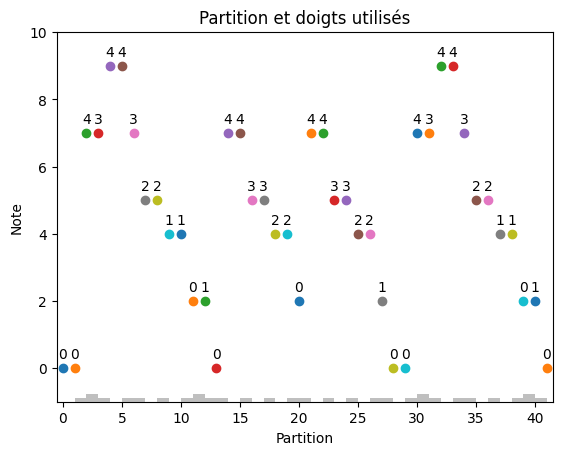

In [ ]:
import math

def progDyn(partition):
    J = [[0 for _ in range(D)], [math.inf for _ in range(D)]] # Tableau de meilleur coût pour la prochaine note et la note actuelle
    T = [[-1 for _ in range(D)] for _ in range(len(partition))] # Tableau retraçant le meilleur doigt de la prochaine note

    for note_index in range(len(partition) - 2, -1, -1): # Complexité de O(n)
        for doigt in range(D): # Complexité de O(D)
            meilleur_cout = math.inf
            meilleur_prochain_doigt = -1
            for prochain_doigt in range(D): # Complexité de O(D)
                cout = costs[partition[note_index], doigt, partition[note_index + 1], prochain_doigt]
                cout += J[0][prochain_doigt]
                if cout < meilleur_cout:
                    meilleur_cout = cout
                    meilleur_prochain_doigt = prochain_doigt
            J[1][doigt] = meilleur_cout
            T[note_index][doigt] = meilleur_prochain_doigt

        J[0] = J[1].copy()
    meilleur_doigt = -1
    meilleur_cout = math.inf
    for doigt, cout in enumerate(J[0]): # Complexité de O(D)
        if cout < meilleur_cout:
            meilleur_cout = cout
            meilleur_doigt = doigt
    premier_doigt = meilleur_doigt
    solution = [premier_doigt]

    for note_index in range(len(partition)): # Complexité de O(n)
        doigt_suivant = T[note_index][solution[-1]]
        if doigt_suivant != -1:
            solution.append(doigt_suivant)

    return solution

solutionDyn = progDyn(partition)
print("Coût Programmation Dynamique :", getTotalCost(costs, partition, solutionDyn))
visualize_solution(costs, partition, solutionDyn)

In [32]:
partition_twinkle_twinkle = readFile('Chansons/twinkle_twinkle.txt')
solutionDyn = progDyn(partition_twinkle_twinkle)
find_difference(solutionDyn, doigts_twinkle_twinkle)

partition_fur_elise = readFile('Chansons/fur_elise.txt')
solutionDyn = progDyn(partition_fur_elise)
find_difference(solutionDyn, doigts_fur_elise)


La solution est la bonne
La solution est la bonne


### Analyse asymptotique

Dans cette analyse, vous tiendrez compte à la fois de la longueur de la mélodie mais également du
nombre de doigts pour chacun des trois algorithmes.

Tel que nous pouvons l'observer dans les commentaires que nous avons laisser dans le code, la complexité asymptotique est de O(N * D<sup>2</sup> + D + N). Nous savons que la complexité sera donc dans O(max(N\*D<sup>2</sup>, D, N)). Nous savons que le nombre de doigts est négligeable par rapport à la longueur de la mélodie. Ces deux valeurs sont strictement positices, donc max(N\*D<sup>2</sup>, D, N) = max(N\*D<sup>2</sup>, N) = N\*D<sup>2</sup>, notre algorithme programmation dynamique est donc dans le O(N\*D<sup>2</sup>) qui est dans O(N)

### Mesures

Rapportez dans un tableau les temps d'exécutions moyens avec les fonctions auxiliaires `measure_procedure` et `display_measure_table`

In [62]:
measure_progDyn = measure_procedure(progDyn, data_set, costs)

display_measures_table(measure_progDyn)


Taille           Temps moyen      Score moyen     
25               1.0              127.66666666666667
50               1.0              414.3333333333333
75               1.6666666666666667 622.6666666666666
100              2.6666666666666665 646.0           
250              5.333333333333333 2033.6666666666667
500              9.0              3666.0          
750              13.333333333333334 5746.666666666667
1000             17.333333333333332 7987.333333333333
1500             27.666666666666668 11639.666666666666
2500             44.0             19402.333333333332
5000             86.33333333333333 38496.333333333336


### Validation empirique

Servez-vous de vos temps d'exécution pour confirmer et/ou préciser l'analyse asymptotique théorique de vos algorithmes avec la méthode hybride de votre choix.

La méthode peut varier d'un algorithme à l'autre. Justifiez les choix ici et avec des graphiques.

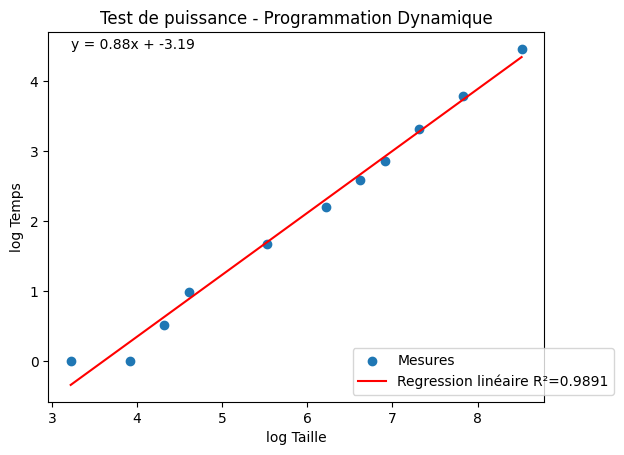

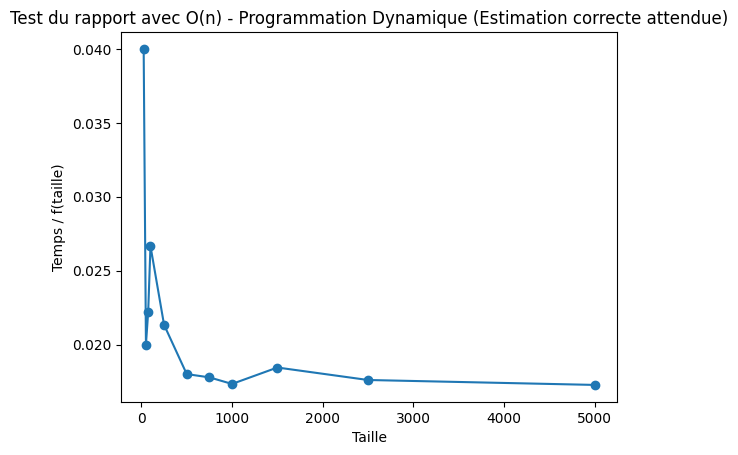

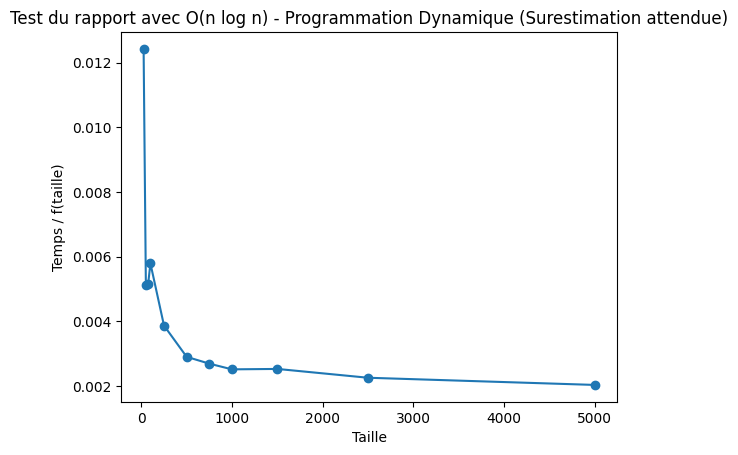

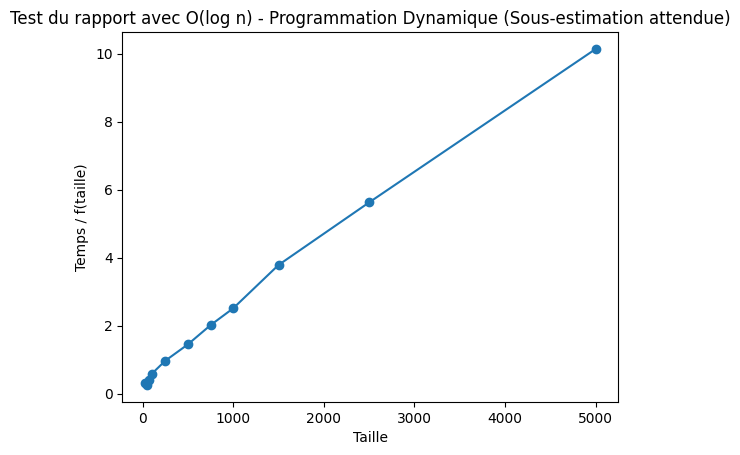

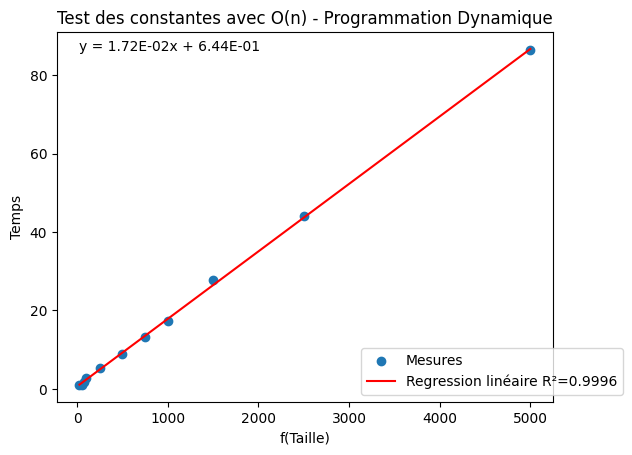

In [63]:
import math
def values_test_puissance(measures):
    return {
        math.log(measure.size): math.log(measure.mean)
        for measure in measures
        }

def values_test_rapport(measures, f):
    return {
        measure.size: measure.mean / f(measure.size)
        for measure in measures
        }

def rapport_fonction(n):
    return n

def rapport_fonction_more_complex(n):
    return n * math.log(n)

def rapport_fonction_less_complex(n):
    return math.log(n)

def values_test_constantes(measures, f):
    return {
        f(measure.size): measure.mean
        for measure in measures
         }

display_test_puissance(values_test_puissance(measure_progDyn), title="Test de puissance - Programmation Dynamique")
display_test_rapport(values_test_rapport(measure_progDyn, rapport_fonction), title="Test du rapport avec O(n) - Programmation Dynamique (Estimation correcte attendue)")
display_test_rapport(values_test_rapport(measure_progDyn, rapport_fonction_more_complex), title="Test du rapport avec O(n log n) - Programmation Dynamique (Surestimation attendue)")
display_test_rapport(values_test_rapport(measure_progDyn, rapport_fonction_less_complex), title="Test du rapport avec O(log n) - Programmation Dynamique (Sous-estimation attendue)")
display_test_constantes(values_test_constantes(measure_progDyn, rapport_fonction), title="Test des constantes avec O(n) - Programmation Dynamique")

1. Le test de puissance nous montre que les résultats suivent une croissance linéaire en O(n<sup>0.88</sup>). Or, comme il peut il y avoir du bruit, il est normal que le résultat de cette régression linéaire soit légèrement inférieure à la réelle complexité algorithmique. Nous concluons donc à une complexité de O(n)

2. 

a. Le graphique du test du rapport pour O(n) montre des valeurs qui tournent autour de 0.017, c'est-à-dire une convergence vers une valeur supérieure à 0. Le graphique confirme donc l'estimation

b. Le graphique du test du rapport pour O(n*log(n)), une surestimation converge bien vers 0, ce qui nous confirme que la complexité algorithmique est inférieure à O(n\*log(n))

c. Le graphique du test du rapport pour O(log(n)), une sous-estimation ne converge pas tel que prévu, ce qui nous confirme que la complexité algorithmique est supérieure à O(log(n))

Ainsi, nous concluons f(n)∈ O(n), O(logn) ⊂ O(n) ⊂ O(nlogn)

3. Enfin pour le test du rapport, on obtiens 

T(n) = (1.72 * 10<sup>-2</sup>) * n + 6.44 * 10<sup>-1</sup>

Nous le vérifions sur certaines tailles utilisées plus haut.

T(2 500) = 43.64 contre  44, soit une erreur de moins de 0.9%

T(5 000) = 86.64 contre 86.3, soit une erreur d'un peu plus de 0.4%

## Partie 3 : Algorithme de recherche locale (6 points)

Cet algorithme explore le voisinage de solutions non optimales. En partant d’une solution gloutonne, la
solution est améliorée en tentant d’échanger un doigt pour un autre sur une note. Vous pourrez prendre
comme critère d’arrêt un nombre maximal d’itérations.

Coût Recherche Locale : 109


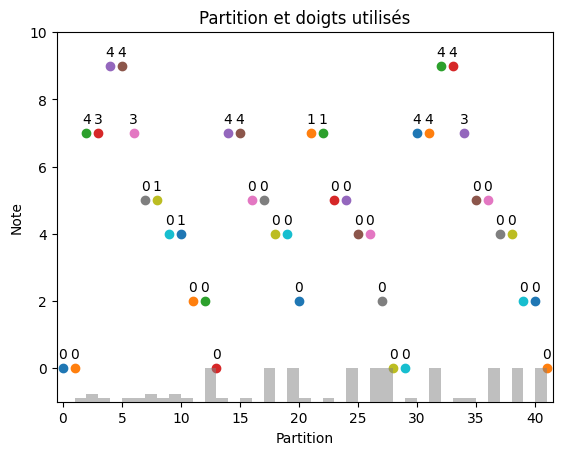

In [54]:
def cout_total(partition, doigts):
    return sum(
        costs[partition[i], doigts[i], partition[i+1], doigts[i+1]]
        for i in range(len(partition) - 1)
    )

def localSearch(partition: list[int], max_iteration: int = 5):
    # Étape 1 : solution initiale (glouton)
    solution = glouton(partition) # Complexité de O(N * D)
    cout_courant = cout_total(partition, solution) # Complexité de O(N)

    for _ in range(max_iteration): # Complexité de O(I)
        meilleur_voisin = solution.copy() # Complexité de O(N)
        meilleur_cout = cout_courant
        amelioration = False

        # Étape 2 : explorer le voisinage
        for i in range(len(partition)): # Complexité de O(N)
            for doigt_alternatif in range(D): # Complexité de O(D)
                if doigt_alternatif == solution[i]:
                    continue  

                voisin = solution.copy() # Complexité de O(N)
                voisin[i] = doigt_alternatif
                cout_voisin = cout_total(partition, voisin) # Complexité de O(N)

                if cout_voisin < meilleur_cout:
                    meilleur_voisin = voisin
                    meilleur_cout = cout_voisin
                    amelioration = True

        
        if amelioration:
            solution = meilleur_voisin
            cout_courant = meilleur_cout
        else:
            break  

    return solution

solutionLocal = localSearch(partition)
print("Coût Recherche Locale :", getTotalCost(costs, partition, solutionLocal))
visualize_solution(costs, partition, solutionLocal)

### Analyse asymptotique

Dans cette analyse, vous tiendrez compte à la fois de la longueur de la mélodie mais également du
nombre de doigts pour chacun des trois algorithmes.

Tel que nous pouvons l'observer dans les commentaires que nous avons laisser dans le code, la complexité asymptotique est de O(N * D + N + I * (N + N * D * (N + N))). Nous savons que la complexité sera donc dans O(max(N\*D, N, I\*N, I\*N\*D\*N)). Nous savons que le nombre de doigts est négligeable par rapport à la longueur de la mélodie et que le "I" qui est le nombre d'itération maximale de recherche locale est aussi négligeable par rapport à la longueur de la mélodie. Ces trois valeurs sont strictement positices, donc max(N\*D, I\*N, I\*N<sup>2</sup>\*D) = max(N\*D, I\*N<sup>2</sup>\*D) = I\*N<sup>2</sup>\*D, notre algorithme programmation dynamique est donc dans le O(I\*N<sup>2</sup>\*D) qui est dans O(N<sup>2</sup>)

### Mesures

Rapportez dans un tableau les temps d'exécutions moyens avec les fonctions auxiliaires `measure_procedure` et `display_measure_table`

In [48]:
measure_localSearch = measure_procedure(localSearch, data_set, costs)

display_measures_table(measure_localSearch)

Taille           Temps moyen      Score moyen     
25               4.666666666666667 160.33333333333334
50               12.666666666666666 488.0           
75               20.666666666666668 966.3333333333334
100              33.0             1152.0          
250              194.66666666666666 3326.0          
500              810.6666666666666 6869.0          
750              1771.0           11545.0         
1000             3283.6666666666665 14534.333333333334
1500             7649.333333333333 22051.0         
2500             28981.0          37577.0         
5000             96385.0          74469.33333333333


### Validation empirique

Servez-vous de vos temps d'exécution pour confirmer et/ou préciser l'analyse asymptotique théorique de vos algorithmes avec la méthode hybride de votre choix.

La méthode peut varier d'un algorithme à l'autre. Justifiez les choix ici et avec des graphiques.

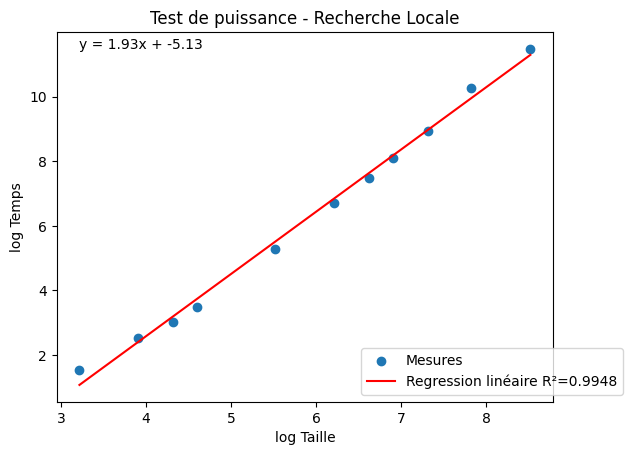

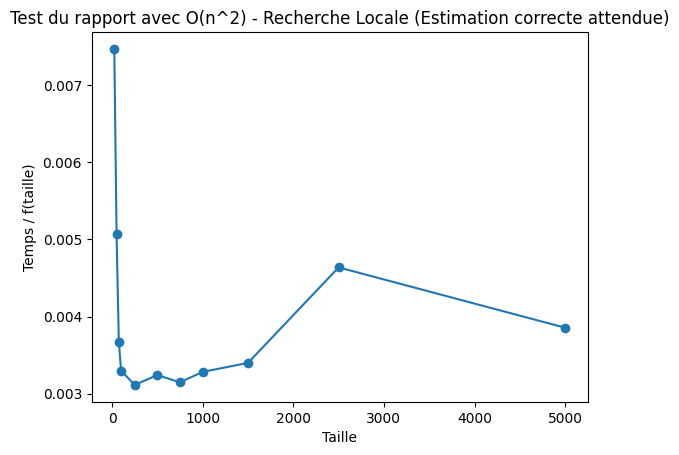

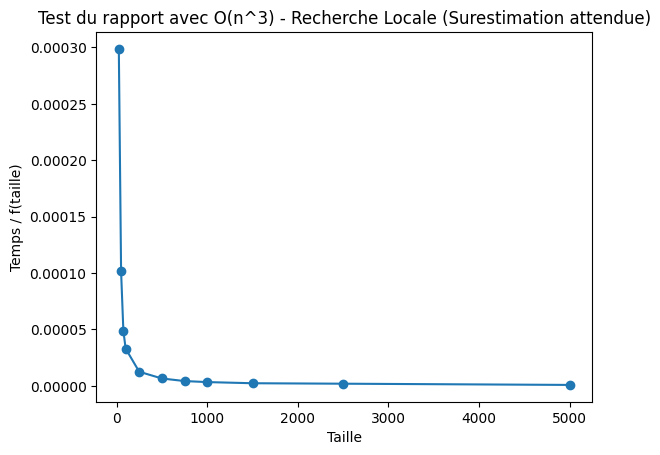

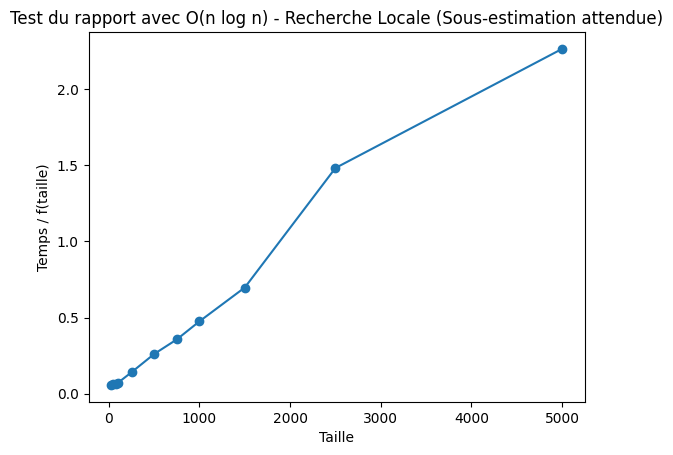

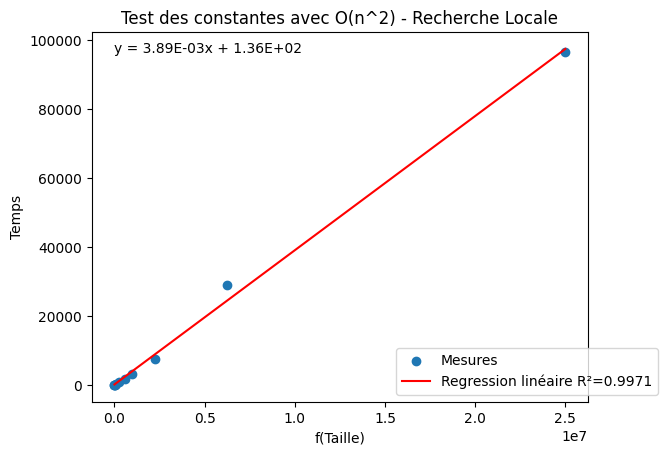

In [56]:
import math
def values_test_puissance(measures):
    return {
        math.log(measure.size): math.log(measure.mean)
        for measure in measures
        }

def values_test_rapport(measures, f):
    return {
        measure.size: measure.mean / f(measure.size)
        for measure in measures
        }

def rapport_fonction(n):
    return n ** 2

def rapport_fonction_more_complex(n):
    return n **3

def rapport_fonction_less_complex(n):
    return n * math.log(n)

def values_test_constantes(measures, f):
    return {
        f(measure.size): measure.mean
        for measure in measures
         }

display_test_puissance(values_test_puissance(measure_localSearch), title="Test de puissance - Recherche Locale")
display_test_rapport(values_test_rapport(measure_localSearch, rapport_fonction), title="Test du rapport avec O(n^2) - Recherche Locale (Estimation correcte attendue)")
display_test_rapport(values_test_rapport(measure_localSearch, rapport_fonction_more_complex), title="Test du rapport avec O(n^3) - Recherche Locale (Surestimation attendue)")
display_test_rapport(values_test_rapport(measure_localSearch, rapport_fonction_less_complex), title="Test du rapport avec O(n log n) - Recherche Locale (Sous-estimation attendue)")
display_test_constantes(values_test_constantes(measure_localSearch, rapport_fonction), title="Test des constantes avec O(n^2) - Recherche Locale")

1. Le test de puissance nous montre que les résultats suivent une croissance linéaire en O(n<sup>1.93</sup>). Or, comme il peut il y avoir du bruit, il est normal que le résultat de cette régression linéaire soit légèrement inférieure à la réelle complexité algorithmique. Nous concluons donc à une complexité de O(n<sup>2</sup>)

2. 

a. Le graphique du test du rapport pour O(n<sup>2</sup>) montre des valeurs qui tournent autour de 0.004, c'est-à-dire une convergence vers une valeur supérieure à 0. Le graphique confirme donc l'estimation

b. Le graphique du test du rapport pour O(n<sup>3</sup>), une surestimation converge bien vers 0, ce qui nous confirme que la complexité algorithmique est inférieure à O(n<sup>3</sup>)

c. Le graphique du test du rapport pour O(n\*log(n)), une sous-estimation ne converge pas tel que prévu, ce qui nous confirme que la complexité algorithmique est supérieure à O(n\*log(n))

Ainsi, nous concluons f(n)∈ O(n<sup>2</sup>), O(n\*logn) ⊂ O(n<sup>2</sup>) ⊂ O(n<sup>3</sup>)

3. Enfin pour le test du rapport, on obtiens 

T(n) = (3.89 * 10<sup>-3</sup>) * n<sup>2</sup> + 1.36 * 10<sup>2</sup>

Nous le vérifions sur certaines tailles utilisées plus haut.

T(2 500) = 24 448 contre 28 981, soit une erreur de moins de 19%

T(5 000) = 97 386 contre 96 385, soit une erreur d'un peu plus de 3%

# Évaluation de la consommation énergétique (1 point)

Dans le cadre de ce TP, nous voulons vous sensibiliser à la consommation énergétique de vos algorithmes. Pour ce faire, nous vous fournissons une librairie que vous pouvez utiliser pour évaluer l'énergie nécessaire à la complétion de votre algorithme (https://mlco2.github.io/codecarbon/). Appelez chacun de vos algorithmes ci-bas avec les mêmes exemplaires et comparez le résultat obtenu par chacun.

In [69]:
#Commande pour installer la librairie
#!pip install codecarbon

from codecarbon import EmissionsTracker

big_partition = generate_sample(10_000)
try:
    tracker = EmissionsTracker(measure_power_secs=5, tracking_mode="process")

    tracker.start_task("glouton")
    glouton(big_partition)
    tracker.stop_task()

    tracker.start_task("dynamic")
    progDyn(big_partition)
    tracker.stop_task()

    tracker.start_task("recherche")
    localSearch(big_partition)
    tracker.stop_task()
finally:
    _ = tracker.stop()

[codecarbon WARNING @ 21:11:49] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 21:11:49] [setup] RAM Tracking...
[codecarbon INFO @ 21:11:49] [setup] CPU Tracking...
[codecarbon WARNING @ 21:11:51] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:11:51] CPU Model on constant consumption mode: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz
[codecarbon WARNING @ 21:11:51] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:11:51] [setup] GPU Tracking...
[codecarbon INFO @ 21:11:51] No GPU found.
[codecarbon INFO @ 21:11:51] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 21:11:51] >>> Tracker's metadata:
[c

Les résultats de l'exécution du code ci-haut devraient apparaître dans un fichier csv. Commentez les résultats obtenus. Vous pouvez trouver une explication de la sortie dans la documentation qui est présente au lien ci-haut.

Les résultats du fichier emissions.csv montrent une différence marquée entre les trois algorithmes du point de vue de la durée d’exécution et de la consommation énergétique.
L’algorithme de programmation dynamique s’avère être le plus rapide, avec une durée d’environ 0,19 seconde, suivi de très près par l’algorithme glouton, qui s’exécute en environ 0,31 seconde.
Ces deux approches ont également une consommation énergétique extrêmement faible, de l’ordre de 10⁻⁸ kWh, et des émissions de CO₂ équivalentes quasi identiques (environ 7,5 × 10⁻⁸ kgCO₂eq).
Cette similarité s’explique par la brièveté de leur exécution et la précision limitée des mesures à ces échelles.

En revanche, l’algorithme de recherche locale présente un comportement très différent : son temps d’exécution atteint environ 657 secondes (plus de 10 minutes), avec une énergie consommée d’environ 5 × 10⁻⁵ kWh, soit plusieurs ordres de grandeur au-dessus des deux autres méthodes.
Cette différence s’explique par la nature itérative de la recherche locale, qui explore de nombreuses solutions voisines à partir d’une solution gloutonne initiale pour tenter d’améliorer le résultat.

En résumé, ces résultats mettent en évidence le lien direct entre complexité algorithmique et empreinte énergétique.
La programmation dynamique est ici la plus efficace, fournissant une solution optimale à coût énergétique minimal.
L’algorithme glouton est presque aussi rapide, mais approximatif.
Enfin, la recherche locale, bien qu’elle puisse raffiner la solution, se révèle nettement plus coûteuse en temps et en énergie, ce qui la rend peu avantageuse dans ce contexte.

# Conclusion et synthèse (2 points)

Résumez succintement vos résultats et analyses, en mettant en évidences les forces et faiblesses de chacun des algorithmes. Indiquez sous quelles conditions vous utiliseriez chacun d'eux.

Nous avons pu déterminer, à travers nos analyses, que pour résoudre le problème du pianiste nous pouvons utiliser un algorithme glouton, un algorithme de programmation dynamique et un algorithme de recherche locale. L'algorithme glouton et dynamique réussissent à avoir une complexité asymptotique O(N), alors que l'algorithme de recherche locale a une complexité asymptotique O(N<sup>2</sup>)

**Glouton:** L'implémentation est simple à faire et l'exécution est efficace. Cependant, il ne trouve pas la solution optimale, mais une solution qui a chaque point est un optimal local et non global. L'algorithme glouton devrait être utilisé lorsque la solution optimal est constitué uniquement de solution optimal locale.  

**Programmation Dynamique:** L'implémentation peut être fastidieuse en fonction du problème. Cependant, il peut trouver la solution optimal au problème et permet de réduire le nombre d'opération grâce au chevaussement des sous-exemplaires. L'algorithme de programmation dynamique devrait être utilisé sur des problèmes qui possède une solution optimale telle qu'un exemplaire est la combinaison des solutions optimales de certains de ses sous-exemplaires. Autrement dit, dans une suite optimale de décisions ou de choix, chaque sous-suite doit aussi être optimale.

**Recherche Locale:** L'implémentation est relativement simple à faire en fonction de la solution initiale trouvée. Cependant, il ne promet que d'améliorer la solution initiale pour aller vers une solution optimale locale. Le grand avantage est qu'il possible, à tout moment, de retourner une solution qui est légèrement meilleure que l'initial. L'algorithme de recherche locale devrait être utilisé sur un autre algorithme simple qui donne une solution non-optimal et s'il est nécessaire de pouvoir retourner une solution légèrment meilleure que l'initial en temps réel.